In [1]:
import numpy as np
import os
#from dicompylercore import dicomparser
import cv2
import lungs_finder as lf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
import matplotlib.pyplot as plt
import math
import sys

Using TensorFlow backend.


In [2]:
def proportional_resize(image, max_side):
    if image.shape[0] > max_side or image.shape[1] > max_side:
        if image.shape[0] > image.shape[1]:
            height = max_side
            width = int(height / image.shape[0] * image.shape[1])
        else:
            width = max_side
            height = int(width / image.shape[1] * image.shape[0])
    else:
        height = image.shape[0]
        width = image.shape[1]
    return cv2.resize(image, (width, height))

In [3]:
# new = true - read dicom, new = false - read png
def prepare_dataset(path, new):
    d_set = []
    labels = []
    folder = path.split(os.sep)[-1]
    if new:
        for path, directories, files in os.walk(path):
            files = [file for file in files if not file[0] == "."]
            for file in files:
                f, extension = os.path.splitext(file)
                label = path.split(os.sep)[-1]
                if extension == ".dcm":
                    parsed = dicomparser.DicomParser(path + os.sep + file)
                    print(file)
                    image = np.array(parsed.GetImage(), dtype=np.uint8)
                    if parsed.GetImageData()["photometricinterpretation"] == "MONOCHROME1":
                        image = 255 - image
                    image = cv2.equalizeHist(image)
                    image = cv2.medianBlur(image, 3)
                    scaled_image = proportional_resize(image, 512)
                    lungs_image = lf.get_lungs(scaled_image, 7)
                    cv2.imwrite("lungs-set" + os.sep + folder + os.sep + label + os.sep + f + ".png", lungs_image)
                    lungs_image = cv2.resize(lungs_image, (128, 128))
                    if label == "norm":
                        d_set.append(lungs_image)
                        labels.append(1)
                    elif label == "pathology":
                        d_set.append(lungs_image)
                        labels.append(0)
                    else:
                        continue
    else:
        path = "../lungs-set" + os.sep + folder
        for path, directories, files in os.walk(path):
            files = [file for file in files if not file[0] == "."]
            for file in files:
                _, extension = os.path.splitext(file)
                label = path.split(os.sep)[-1]
                parsed = cv2.imread(path + os.sep + file, 0)
                image = np.array(parsed, dtype=np.uint8)
                lungs_image = cv2.resize(image, (256, 256))
                if label == "norm":
                    d_set.append(lungs_image)
                    labels.append(1)
                elif label == "pathology":
                    d_set.append(lungs_image)
                    labels.append(0)
                else:
                    continue
    return np.array(d_set), np.array(labels)

In [4]:
# downloading the dataset
np.random.seed(42)
def_width = 256
def_height = 256
train = "/Volumes/DATA/KAMI/lung_dataset/train"
test = "/Volumes/DATA/KAMI/lung_dataset/test"
x_train, y_train = prepare_dataset(train, False)
x_test, y_test = prepare_dataset(test, False)
# optional to shuffle the dataset
#x_train, y_train = shuffle(x_train, y_train, random_state=0)
#x_test, y_test = shuffle(x_test, y_test, random_state=0)
x_train = x_train.astype(dtype="float32")
x_test = x_test.astype(dtype="float32")
x_train /= 255
x_test /= 255
x_train = x_train.reshape(x_train.shape[0], def_width, def_height, 1)
x_test = x_test.reshape(x_test.shape[0], def_width, def_height, 1)
y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)

In [5]:
# load json and create model
json_file = open('../model_256.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("../weights_256.h5")
# evaluate loaded model on test data
loaded_model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 70.50%


In [6]:
# function of plotting feature maps
%matplotlib inline
# start,end - range of feature maps to visualise
def visualize_features(model, lung, start, end):
    lung_batch = np.expand_dims(lung,axis=0)
    conv_lung = model.predict(lung_batch)
    conv_lung = np.squeeze(conv_lung, axis=0)
    rows = math.ceil((end - start)/4)
    fig = plt.figure(figsize=(16, rows*4))
    k=1
    for i in range(start,end):
        img = conv_lung[:,:,i]
        plt.subplot(rows,4,k)
        k+=1
        plt.yscale('linear')
        plt.imshow(img, cmap=plt.cm.gray)
        plt.title(i)
        plt.grid(True)
    fig.tight_layout()
    plt.show()

Predicted classes: [[ 0.86945385  0.13054615]]
Real classes: [ 1.  0.]


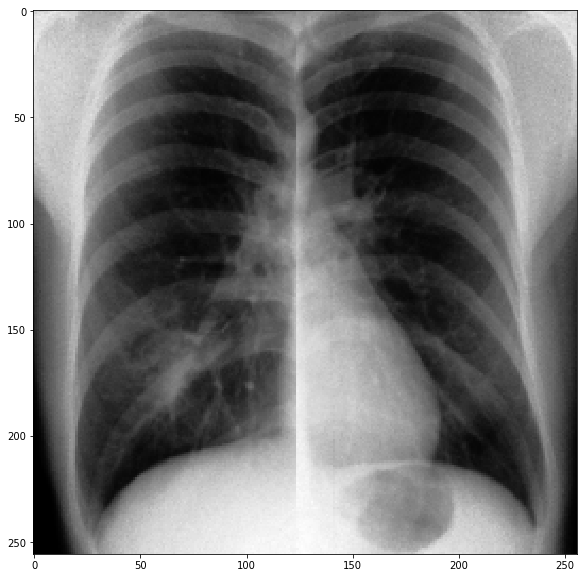

In [7]:
# select a number of convolutional or pooling layer to visualise it's features
lay_num = 10
# select a number of image from the test dataset
im_to_visual = 299
conv_layer = loaded_model.layers[lay_num]
model = Sequential()
model.add(conv_layer)
# plotting the original image
f1 = plt.figure(figsize=(10,10))
img = np.squeeze(x_test[im_to_visual], axis=2)
plt.imshow(img,cmap=plt.cm.gray)
batch_im = np.expand_dims(x_test[im_to_visual],axis=0)
res = loaded_model.predict(batch_im)
print("Predicted classes: " + str(res))
print("Real classes: " + str(y_test[im_to_visual]))

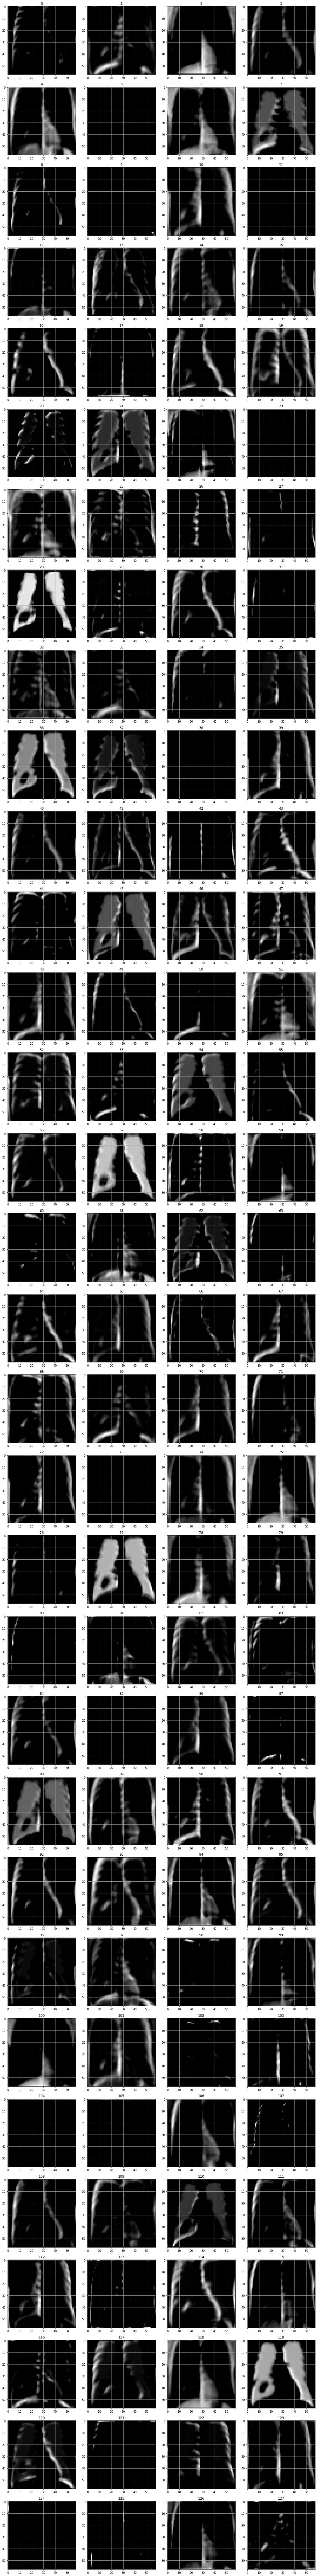

In [8]:
# the function of visualising feature maps
# visualize_features(model, image_to_visualise, start_feature, end_feature)
visualize_features(model, x_test[im_to_visual],0,128)

In [13]:
def buildHeatMap(in_img, window_size=32, step=8, isBlack=True):
    # the paragraph of building the heatmap
    # set the window size, for now it's a square shape
    window_size=window_size
    # set a stride of the window
    step=step
    test_img = in_img
    test_img = np.squeeze(test_img, axis=2)
    img_width=test_img.shape[0]
    img_height=test_img.shape[1]
    # preparing the canvas with black border
    if isBlack:
        canvas = np.zeros((img_width+(window_size-step)*2,img_height+(window_size-step)*2))
    else:
        canvas = np.ones((img_width+(window_size-step)*2,img_height+(window_size-step)*2))
    c_w=canvas.shape[0]
    c_h=canvas.shape[1]
    heat_arr = np.zeros((c_w,c_h))
    # start point
    st_point=0
    for i in range(st_point,c_w-window_size+1,step):
        out = (str(int((i/(c_w-window_size+1))*100))+"% is complete")
        sys.stdout.write('\r'+out)
        for j in range(st_point,c_h-window_size+1,step):
            new_img = np.copy(test_img)
            canvas[window_size-step:c_w-window_size+step,window_size-step:c_h-window_size+step]=new_img
            if isBlack:
                canvas[i:i+window_size,j:j+window_size]=np.zeros((window_size,window_size))
            else:
                canvas[i:i+window_size,j:j+window_size]=np.ones((window_size,window_size))
            new_img = canvas[window_size-step:c_w-window_size+step,window_size-step:c_h-window_size+step]
            new_img = new_img.reshape(1,new_img.shape[0],new_img.shape[1],1)
            # make a prediction with the occluded image
            pred = loaded_model.predict(new_img)
            pred_arr = np.full((window_size,window_size),pred[0][0])
            heat_arr[i:i+window_size,j:j+window_size]+=pred_arr
    # plot the heatmap without cropping the borders
    #f2 = plt.figure(figsize=(5,5))
    #plt.imshow(heat_arr,cmap=plt.cm.coolwarm)
    return heat_arr

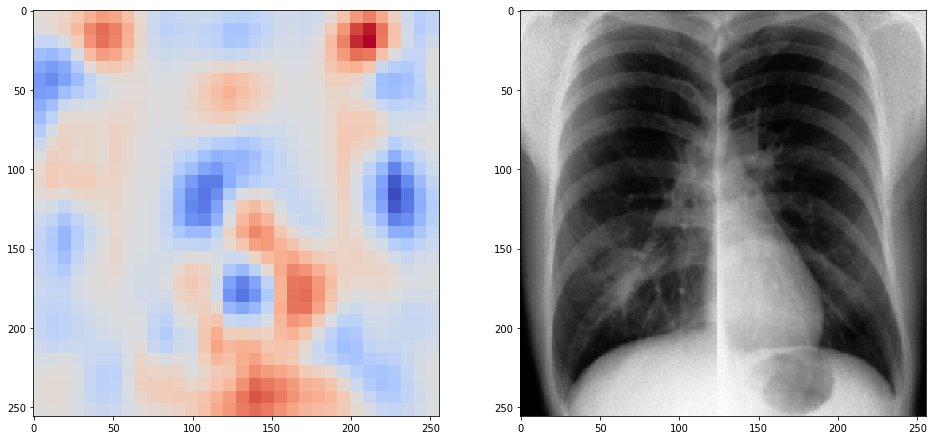

In [46]:
# cropping the borders
heat_map = heat_arr[window_size-step:c_w-window_size+step,window_size-step:c_h-window_size+step]
# plot the heatmap and original x-ray in 1 row
f3 = plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(heat_map,cmap=plt.cm.coolwarm)
plt.subplot(1,2,2)
plt.imshow(test_img,cmap=plt.cm.gray)

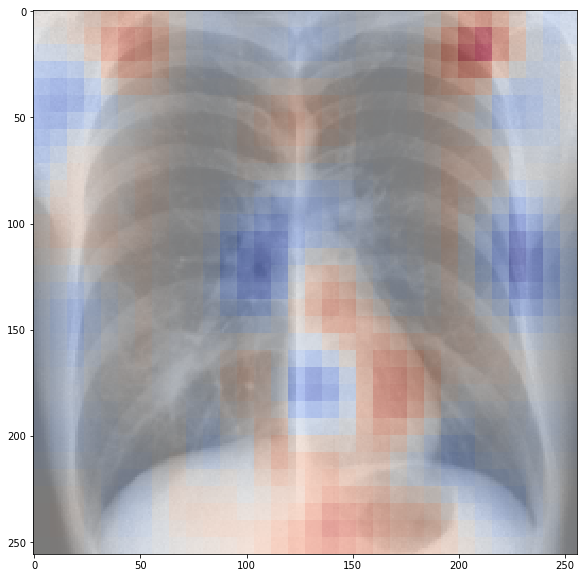

In [44]:
# plotting the heatmap and x-ray in one plot
f4 = plt.figure(figsize=(10,10))
plt.imshow(test_img,cmap=plt.cm.gray,alpha=0.9)
plt.imshow(heat_map,cmap=plt.cm.coolwarm,alpha=0.5)

In [ ]:
st_img=300
fin_img=301
for idx in range(st_img,fin_img):
    print("Processing images: ",idx-st_img+1," of", fin_img-st_img)
    curr_img = x_test[idx]
    batch_curr_img = curr_img.reshape(1,curr_img.shape[0],curr_img.shape[1],curr_img.shape[2])
    heat_arr = buildHeatMap(curr_img, 32, 4, True)
    # cropping the borders
    heat_map = heat_arr[window_size-step:c_w-window_size+step,window_size-step:c_h-window_size+step]
    # plot the heatmap and original and combo
    fig_w=16
    fig_h=24
    f3 = plt.figure(figsize=(fig_w,fig_h))
    w1=int((fig_w/2-1))
    h1=int((fig_w/2-1))
    plt.subplot2grid((fig_h,fig_w),(0,0), colspan=w1, rowspan=h1)
    plt.imshow(heat_map,cmap=plt.cm.coolwarm)
    plt.subplot2grid((fig_h,fig_w),(0,int((fig_w/2)+1)), colspan=w1,rowspan=h1)
    plt.imshow(test_img,cmap=plt.cm.gray)
    plt.subplot2grid((fig_h,fig_w),(int(fig_w/2),0), colspan=fig_w, rowspan=fig_w)
    plt.imshow(test_img,cmap=plt.cm.gray,alpha=0.95)
    plt.imshow(heat_map,cmap=plt.cm.coolwarm,alpha=0.4)
    f3.subplots_adjust(top=0.97, bottom=0, left=0, right=1, hspace=0,
                        wspace=0)
    res = loaded_model.predict(batch_curr_img)
    string="Predicted classes: " + str(res)
    string+=("\nReal classes: " + str(y_test[im_to_visual]))
    f3.suptitle(string,fontsize=14, fontweight='bold')
    f3.savefig(str(curr_img))

Processing images:  1  of 1
54% is complete